In [253]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn import decomposition
import numpy as np
import pandas as pd
import spacy
import re
from spacy.lang.en.stop_words import STOP_WORDS
stopword_list = list(STOP_WORDS)
nlp_en = spacy.load('en_core_web_sm')

In [252]:
df = pd.read_csv(r"C:\Users\nasre\Desktop\patents_30.csv") 
df.head()

,AE,TI,AB,Year,CP,AE_ABBREV
0,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for handshaking terminal in radio commu...,NOVELTY - The method involves noticing firs...,2018,WO2018084624-A1 -- WO2010082775-A2 LG ELECTR...,(SMSU-C)
1,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for handling control data by mobility m...,NOVELTY - The method involves receiving a n...,2018,WO2018008977-A1 -- KR2013103428-A SAMSUNG EL...,(SMSU-C)
2,HUAWEI TECHNOLOGIES CO LTD (HUAW-C),Method for receiving channel state information...,NOVELTY - The method involves receiving a n...,2017,WO2017114474-A1 -- CN101394378-A INNOFIDEI T...,(HUAW-C)
3,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for receiving signal in receiving appar...,NOVELTY - The method involves decoding a co...,2017,US2017187491-A1 -- US20050216821-A1 ; US788...,(SMSU-C)
4,QUALCOMM INC (QCOM-C),Wireless communication method for over-the-air...,NOVELTY - The method involves receiving (50...,2018,; WO2018236480-A1 -- EP2154802-A1 MITSUBISH...,(QCOM-C)


In [53]:
!pip install nlp

!pip install spacy

!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [254]:
df['text'] = df['TI'] + ". " + df['AB'] #title followed by a period and then the abstractdf
df.head()

,AE,TI,AB,Year,CP,AE_ABBREV,text
0,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for handshaking terminal in radio commu...,NOVELTY - The method involves noticing firs...,2018,WO2018084624-A1 -- WO2010082775-A2 LG ELECTR...,(SMSU-C),Method for handshaking terminal in radio commu...
1,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for handling control data by mobility m...,NOVELTY - The method involves receiving a n...,2018,WO2018008977-A1 -- KR2013103428-A SAMSUNG EL...,(SMSU-C),Method for handling control data by mobility m...
2,HUAWEI TECHNOLOGIES CO LTD (HUAW-C),Method for receiving channel state information...,NOVELTY - The method involves receiving a n...,2017,WO2017114474-A1 -- CN101394378-A INNOFIDEI T...,(HUAW-C),Method for receiving channel state information...
3,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for receiving signal in receiving appar...,NOVELTY - The method involves decoding a co...,2017,US2017187491-A1 -- US20050216821-A1 ; US788...,(SMSU-C),Method for receiving signal in receiving appar...
4,QUALCOMM INC (QCOM-C),Wireless communication method for over-the-air...,NOVELTY - The method involves receiving (50...,2018,; WO2018236480-A1 -- EP2154802-A1 MITSUBISH...,(QCOM-C),Wireless communication method for over-the-air...


# Preprocessing the data

In [255]:
def preprocess(txt):
    txt = txt.lower() #normalize text
    txt = re.sub(r'[^a-zA-Z]', ' ', txt)
    docs = nlp_en(txt)
    #lemmatize and remove stopwords
    word_list = [doc.lemma_ for doc in docs if doc.text 
                            not in stopword_list ]
    txt = " ".join(word_list)
    txt = txt.replace("-PRON-","")
    txt = txt.replace("PRON","")
    return txt

# NMF Model for the 40 topics using Tfidf vectorizer

In [193]:
corpus = list(df['text'])

In [194]:
cleaned_corpus = [preprocess(txt) for txt in corpus]

In [195]:
vectorizer_nmf = TfidfVectorizer(stop_words = 'english', min_df = 2)
dtm_nmf = vectorizer_nmf.fit_transform(cleaned_corpus)

In [243]:
vocab = vectorizer_nmf.get_feature_names_out()
num_topics = 40
num_top_words = 20
clf = decomposition.NMF(n_components = num_topics, random_state=40)
doctopic = clf.fit_transform(dtm_nmf)
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: control downlink dci pdcch search space physical monitor pdsch set candidate receive monitoring tci format
Topic 1: network core access element equipment connection user radio method generation area traffic second facilitate public
Topic 2: device send mobile phone computer electronic second network indication facilitate telephone personal instruction step cellular
Topic 3: ue equipment user mode location capability nr rat processor radio bs connection method associate procedure
Topic 4: unit control mobile radio user communication lte ieee access reception future advanced generation new ultra
Topic 5: antenna module electronic circuit second array element connect surface radiator conductive structure switch form substrate
Topic 6: beam failure recovery quality candidate pair select set receive form reception determine direction bfr procedure
Topic 7: station base transmit receive radio rrc interference connection fourth generation second smart secondary method claim
Topic 8: 

C:\Users\nasre\AppData\Roaming\Python\Python38\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


# LDA Model using Gensim

In [205]:
n = 40

In [204]:
#converting corpus to a list of words
cleaned_corpus = [txt.split() for txt in cleaned_corpus]

In [206]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(cleaned_corpus)

# Filter out words that occur less than 10 documents, or more than 80% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.8)

In [207]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in cleaned_corpus]

In [209]:
# LDA model.
from gensim.models import LdaModel

# Training parameters.
num_topics = 40
chunksize = 3000
passes = 40
iterations = 1000
eval_every = None 

# Making an index to word dictionary.
temp = dictionary[0]  
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [210]:
top_topics = model.top_topics(corpus) 

avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -2.1931.
[([(0.10339611, 'unit'),
   (0.078223355, 'terminal'),
   (0.07483387, 'control'),
   (0.055091236, 'system'),
   (0.04337746, 'user'),
   (0.037486933, 'mobile'),
   (0.03622707, 'transmission'),
   (0.030601671, 'information'),
   (0.02934308, 'wireless'),
   (0.026183823, 'base'),
   (0.026023941, 'apparatus'),
   (0.018417936, 'station'),
   (0.01726244, 'reception'),
   (0.0154390745, 'radio'),
   (0.01482697, 'text'),
   (0.014783277, 'language'),
   (0.014766645, 'english'),
   (0.012872245, 'non'),
   (0.012475935, 'receive'),
   (0.010870639, 'lte')],
  -0.6998266516532594),
 ([(0.19582018, 'information'),
   (0.07091244, 'terminal'),
   (0.038750987, 'send'),
   (0.03484177, 'device'),
   (0.034432147, 'system'),
   (0.030180426, 'involve'),
   (0.029411845, 'accord'),
   (0.024220537, 'receive'),
   (0.023300584, 'step'),
   (0.022873431, 'determine'),
   (0.022623125, 'indication'),
   (0.020727994, 'non'),
   (0.020598272, 'text'),
   (0.0

In [211]:
for i in range(40):
    print("Topic: " + str(i + 1) + ":")
    a, b = zip(*top_topics[i][0])
    for w in b:
        print(w, end=', ')
    print("\n")    

Topic: 1:
unit, terminal, control, system, user, mobile, transmission, information, wireless, base, apparatus, station, reception, radio, text, language, english, non, receive, lte, 

Topic: 2:
information, terminal, send, device, system, involve, accord, receive, step, determine, indication, non, text, english, language, computer, obtain, storage, instruction, medium, 

Topic: 3:
terminal, device, system, mobile, send, network, step, access, division, lte, target, determine, set, aa, evolution, information, involve, term, long, comprise, 

Topic: 4:
network, device, wireless, access, second, core, cellular, radio, computer, program, provide, establish, comprise, medium, follow, involve, instruction, receive, allow, control, 

Topic: 5:
system, lte, radio, access, mobile, evolution, term, long, new, advanced, nr, technology, ieee, telecommunication, e, ultra, gsm, global, limit, code, 

Topic: 6:
carrier, system, multiple, wireless, division, symbol, frequency, access, sub, base, ortho

# Hierarchical cluster and MDS Map of companies

In [262]:
df['Lemmatized'] = [preprocess(txt) for txt in df['text'].tolist()]

In [268]:
companies = list(set(df['AE_ABBREV'].tolist()))
corpus1 = []
for company in companies:
    alist = ' '.join(df[df['AE_ABBREV'] == company]['Lemmatized'].tolist())
    corpus1.append(alist)

In [269]:
print(companies)

['(CHGY-C)', '(BBKO-C)', '(OYNO-C)', '(FUIT-C)', '(AMTT-C)', '(KTKT-C)', '(SONY-C)', '(XIAO-C)', '(ZTEC-C)', '(GDOP-C)', '(MTEK-C)', '(QCOM-C)', '(GLDS-C)', '(NIDE-C)', '(TELF-C)', '(SHAF-C)', '(VEZN-C)', '(ITLC-C)', '(TMOB-C)', '(SMSU-C)', '(CNMO-C)', '(NITE-C)', '(APPY-C)', '(HUAW-C)', '(CUNC-C)', '(FGIN-C)', '(DTCO-C)']


In [270]:
print(companies[0], corpus1[0])
print(companies[26], corpus1[26])

(CHGY-C) method update hop chain counter   ncc   reduce frequency terminal key update mobile communication network   involve set security update timer counter user equipment   determine update ncc      novelty    method involve set        security update timer counter user equipment   ue   enter inactive state   determination        update ncc ue accord packet datum aggregation protocol   pdcp   entity change   security update timer expire counter reach threshold      use    method update ncc reduce frequency terminal key update generation mobile communication network   apply computing device   claim       advantage    high flexibility provide security requirement future fifth generation mobile communication system      detailed description    independent claim include following          base station          device update ncc reduce frequency terminal key update generation mobile communication network          computing device           computer readable storage medium store instructi

In [283]:
vectorizer1 = CountVectorizer(stop_words = 'english', min_df = 2, max_df = 0.95, max_features=10000)
dtm = vectorizer1.fit_transform(corpus1)
#cosine similarity
similarity = cosine_similarity(dtm)
#convert to distance
cos_distance = 1 - similarity

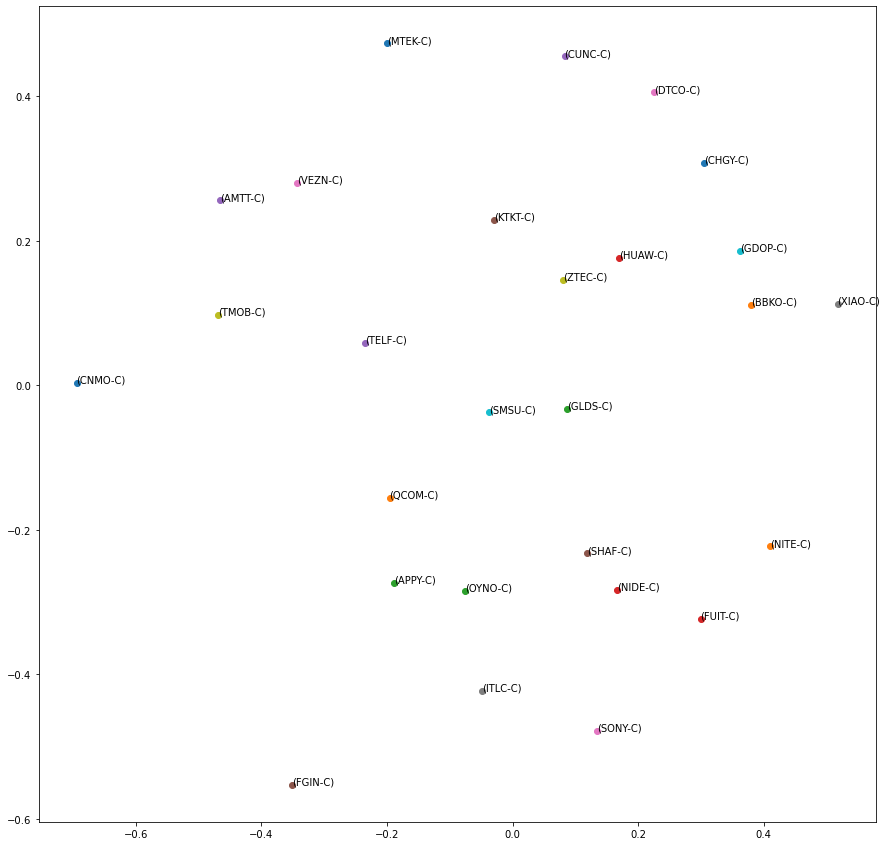

In [288]:
mds = MDS(n_components = 2, dissimilarity='precomputed', random_state=48)
pos = mds.fit_transform(cos_distance)
xs, ys = pos[:,0], pos[:,1]
plt.figure(figsize=(15, 15))
for x, y, name in zip(xs, ys, companies):
    plt.scatter(x, y)
    plt.text(x, y, name)
plt.show()

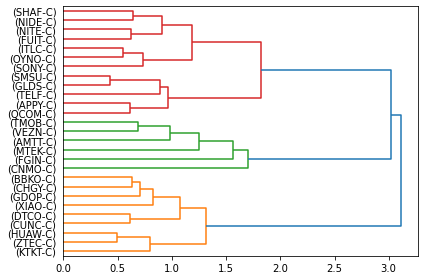

In [287]:
linkage_matrix = ward(cos_distance)
dendrogram(linkage_matrix, orientation='right',labels=companies)
plt.tight_layout()
plt.show()